# Prepare reference data

## Summary

Below is a brief tutorial that shows you how we prepared a scRNA-seq data set so that it is ready to be used to train a PySCN classifier. In general, any scRNA-seq data can be used as training data, as long as it is carefully annotated and the raw expression counts are maintained. See [Reference data](training-data.md) to browse other reference data sets that we have compiled. In this tutorial, we assume that you have already installed PySCN. We use the terms "reference" and "training" interchangebly.

## Training data

We use the "10k PBMCs from a Healthy Donor (v3 chemistry) Single Cell Gene Expression Dataset by Cell Ranger 3.0.0" data set from 10X Genomics.

- You can learn more about 10k PBMC data from the [10X page](https://www.10xgenomics.com/resources/datasets/10-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0)
- Healthy human donor Peripheral blood mononuclear cells (PBMC).
- 11,769 cells
- 54,000 reads per cell
- [filtered data set in h5 format](https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.h5)


## Load packages and raw data

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import anndata
import pySingleCellNet as pySCN
import igraph as ig
import altair as alt
from joblib import dump, load
import sys

sc.settings.verbosity = 3 
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.0 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.9.11 pynndescent==0.5.8


Load 10k PBMC data

In [2]:
ad10f = sc.read_10x_h5("../../dat/pbmc/pbmc_10k_v3_filtered_feature_bc_matrix.h5")
ad10f.var_names_make_unique()
ad10f

reading ../../dat/pbmc/pbmc_10k_v3_filtered_feature_bc_matrix.h5
 (0:00:00)


/opt/homebrew/Caskroom/miniforge/base/envs/test1/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

## Quality control

Start the QC process. `pySCN.mito_rib` computes the proportion of counts derived from mitochondrially-encoded genes and ribosomal genes. By default, it will also remove these genes from the annData object.

In [3]:
adstart = ad10f.copy()
adstart = pySCN.mito_rib(adstart, species='HS', clean = True)
adstart

AnnData object with n_obs × n_vars = 11769 × 33421
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

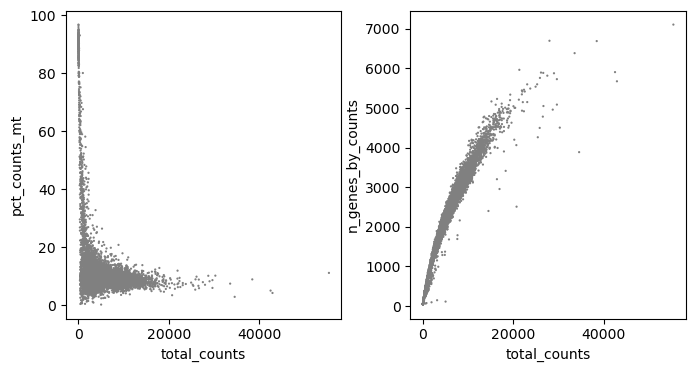

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.scatter(adstart, x='total_counts', y='pct_counts_mt', ax=ax1, show=False)
ax2_dict = sc.pl.scatter(adstart, x='total_counts', y='n_genes_by_counts',ax=ax2, show=False)
plt.show()

Let's keep cells that ...

- mt% < 20
- n_genes >= 500
- n_counts <= 30,000

And exclude genes that are detected in 2 or fewer cells

In [5]:
adstart = adstart[adstart.obs['pct_counts_mt']<20,:].copy()
adstart.n_obs
sc.pp.filter_cells(adstart, min_genes=500)
adstart.n_obs
sc.pp.filter_cells(adstart, max_counts=30000)
adstart.n_obs
sc.pp.filter_genes(adstart, min_cells=3)
adstart.n_vars


filtered out 139 cells that have less than 500 genes expressed
filtered out 7 cells that have more than 30000 counts
filtered out 13317 genes that are detected in less than 3 cells


20104

## Normalize and reduce dimentionality

Normalize expression, detect highly variable genes (HVG), and run PCA. 

:::{note}
`pySCN.norm_hvg_scale_pca` does not scale expression values by default. Set gene_scale = True if you want to scale gene expression.
:::

In [6]:
adNorm = pySCN.norm_hvg_scale_pca(adstart)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:03)


Plot variance ratios

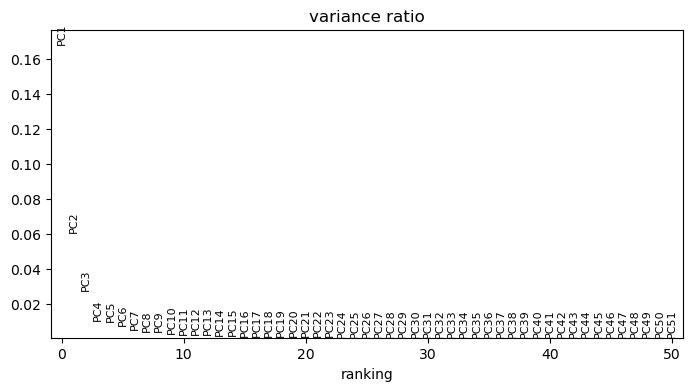

In [7]:
plt.rcParams["figure.figsize"] = (8,4)
sc.pl.pca_variance_ratio(adNorm, 50)

## Embed data and cluster

Embed with UMAP based on first 11 PCs, and see how QC metrics track with clusters.

computing neighbors
    using 'X_pca' with n_pcs = 11
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


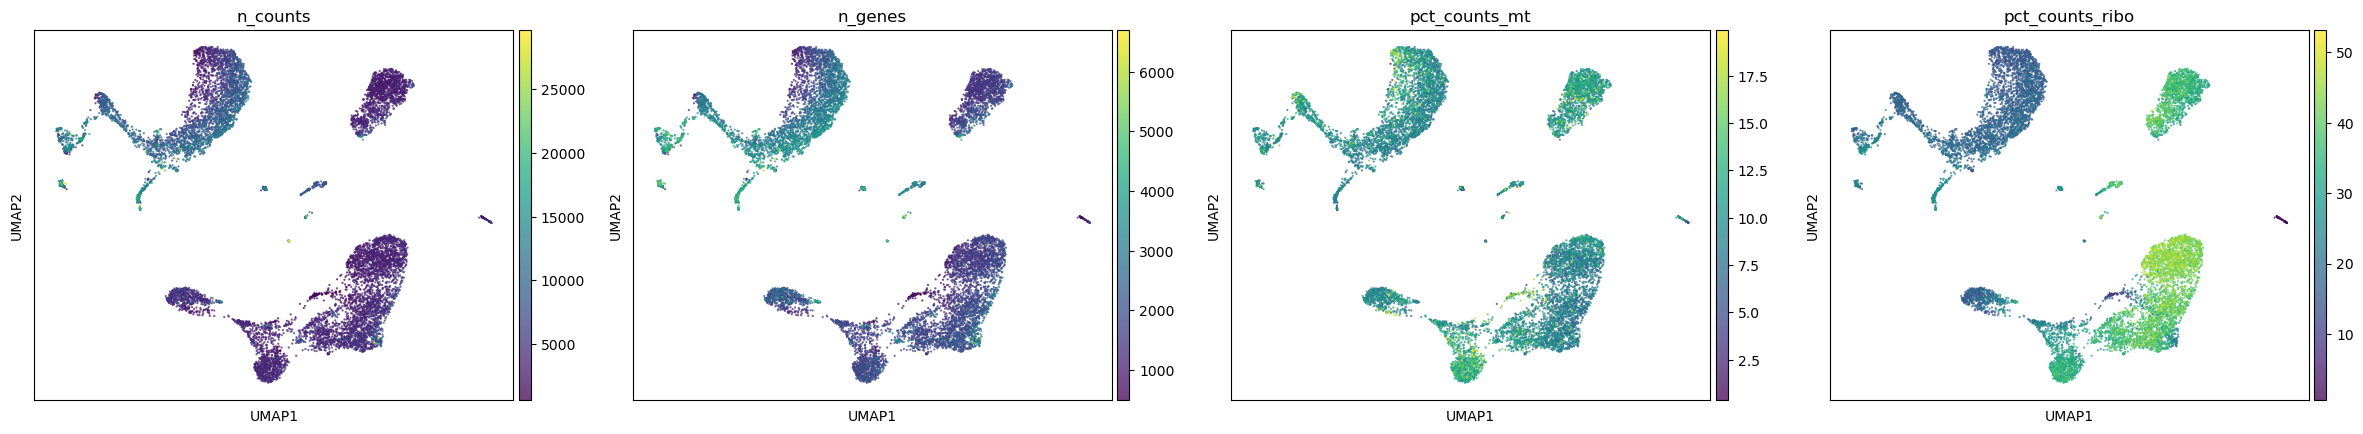

In [8]:
npcs = 11
sc.pp.neighbors(adNorm, n_neighbors=20, n_pcs=npcs)
sc.tl.leiden(adNorm,.1)

sc.tl.paga(adNorm)
sc.pl.paga(adNorm, plot=False)
sc.tl.umap(adNorm, 0.25, init_pos='paga')

plt.rcdefaults()
#plt.subplots(layout="constrained")
sc.pl.umap(adNorm,color=['n_counts', 'n_genes', 'pct_counts_mt', 'pct_counts_ribo'], alpha=.75, s=10)

## Cluster annotation

Manually annotate the cells based on established markers of various PBMC cell types.

In [9]:
marker_genes_dict = {
    'B cell': ['CD79A', 'MS4A1', "PAX5"],
    'Dendritic': ['FCER1A', "FLT3","CD1C"],
    'CD14 monocyte': ['CD14', "CD36"],
    'FCGR3A monocyte': ['FCGR3A', 'MS4A7'],
    'NK cell': ['GNLY',"KLRD1", "PRF1"],
    'Megakaryocyte': ['PPBP',"PF4", "GNG11"],
    'CD4 T cell': ['CD3D', 'IL7R', "CD3E"],
    'CD8 T cell': ['CD8A', "EOMES"]
}

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: B cell, Dendritic, CD14 monocyte, etc.


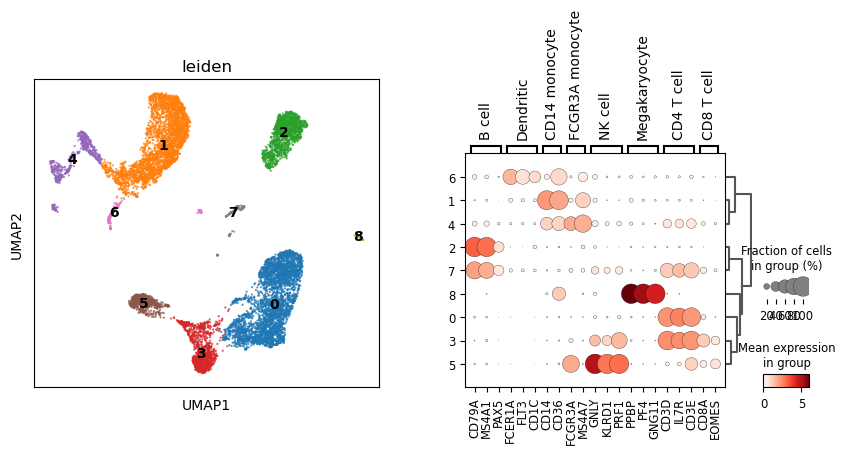

In [10]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adNorm,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adNorm, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

Based on the expression of these marker genes, here is an initial guess at their identities:

- 6: dendritic, but split more because it looks like there might be some monocytes in there
- 1: CD14+ monocyte
- 4: split more (dual monocyte type) or doublet
- 2: b-cell possible pre/pro
- 7: split further (dual T- B-cell) or doublet
- 8: megakaryocyte
- 0: CD4+ T-cell
- 3: CD8+ T-cell
- 5: NK cell

Since some of the clusters might contain mixtures of cell types, or are doublets, try to fractionate them further.

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden_R']`
categories: 0, 1, 2, etc.
var_group_labels: B cell, Dendritic, CD14 monocyte, etc.


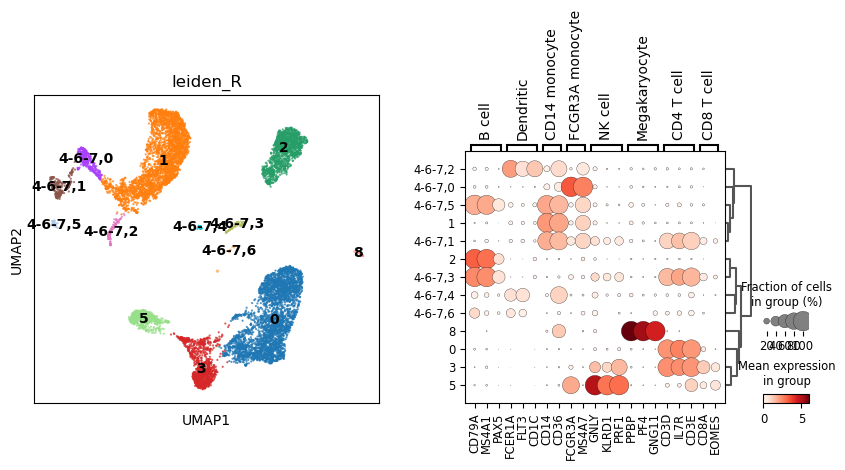

In [11]:
sc.tl.leiden(adNorm,.15, restrict_to=["leiden",["4", "6", "7"]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adNorm,color=['leiden_R'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adNorm, marker_genes_dict, 'leiden_R', dendrogram=True,ax=ax2, show=False)
plt.show()

Based on these results, our final cluster annotation is as follows:

- 4-6-7,2: dendritic
- 4-6-7,0: FCGR3A+ monocyte
- 4-6-7,5: doublet
- 1: CD14+ monocyte
- 4-6-7,1:doublet
- 2: B cell
- 4-6-7,3: doublet
- 4-6-7,4: doublet
- 4-6-7,6: doublet
- 8: Megakaryocyte
- 0: CD4 T cell
- 3: CD8 T cell
- 5: NK cell

Leaving 8 legitimate clusters. So let's remove the clusters that seem to be doublets.

In [12]:
tokeep = ["4-6-7,2","4-6-7,0", "1", "2", "8", "0", "3", "5"]
adClean2 = adstart.copy()
adClean2 = adClean2[adNorm.obs['leiden_R'].isin(tokeep)].copy()
adClean2

AnnData object with n_obs × n_vars = 10309 × 20104
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [13]:
adNorm2 = pySCN.norm_hvg_scale_pca(adClean2)
adNorm2.obs['cluster'] = adNorm[adNorm2.obs.index].obs['leiden_R'].copy()
npcs = 11
sc.pp.neighbors(adNorm2, n_neighbors=20, n_pcs=npcs)
sc.tl.leiden(adNorm2,.1)
sc.tl.paga(adNorm2)
sc.pl.paga(adNorm2, plot=False)
sc.tl.umap(adNorm2, 0.25, init_pos='paga')

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 11
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    fini

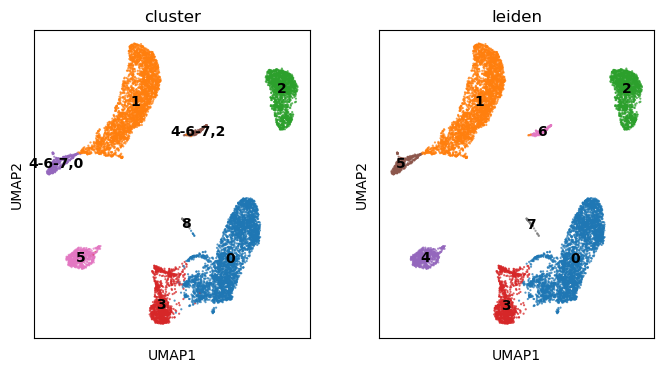

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adNorm2,color=['cluster'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.umap(adNorm2,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax2, show=False)
plt.show()

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: B cell, Dendritic, CD14 monocyte, etc.


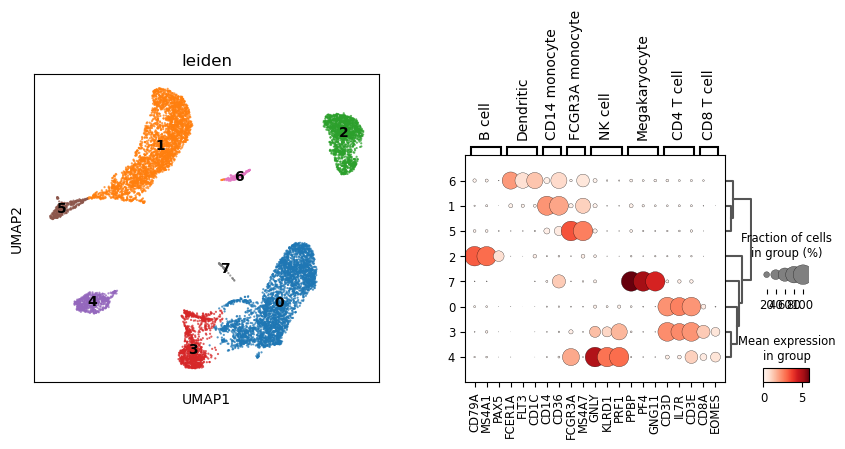

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.25})
ax1_dict = sc.pl.umap(adNorm2,color=['leiden'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adNorm2, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
plt.show()

Add the final cell annotations to the annData object:

- 6: Dendritic
- 1: CD14+ monocyte
- 5: FCGR3A+ monocyte
- 2: B cell
- 7: Megakaryocyte
- 0: CD4 T cell
- 3: CD8 T cell
- 4: NK cell


In [16]:
cell_dict = {'Dendritic': ['6'],
             'CD14 monocyte': ['1'],
             'FCGR3A monocyte': ['5'],
             'B cell': ['2'],
             'Megakaryocyte': ['7'],
             'CD4 T cell': ['0'],
             'CD8 T cell': ['3'],
             'NK cell': ['4']
}

In [17]:
new_obs_name = 'cell_type'
adNorm2.obs[new_obs_name] = np.nan

for i in cell_dict.keys():
    ind = pd.Series(adNorm2.obs.leiden).isin(cell_dict[i])
    adNorm2.obs.loc[ind,new_obs_name] = i

adNorm2.obs['cell_type'] = adNorm2.obs['cell_type'].astype("category") 

In [18]:
sc.tl.dendrogram(adNorm2, "cell_type")

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_cell_type']`


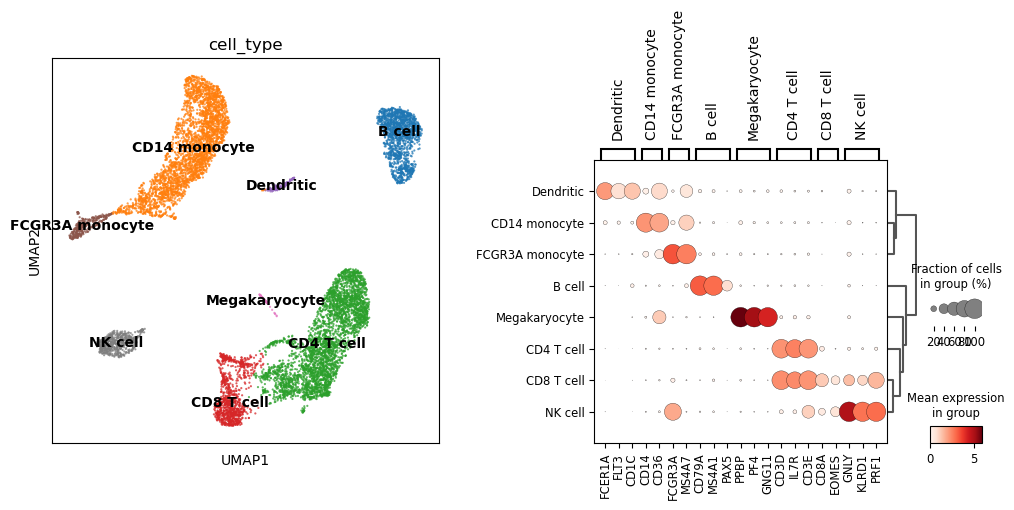

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'wspace':0.4})
ax1_dict = sc.pl.umap(adNorm2,color=['cell_type'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adNorm2, marker_genes_dict, 'cell_type', dendrogram=True,ax=ax2, show=False)
plt.show()

In [20]:
adNorm2.obs['cell_type'].value_counts()

cell_type
CD4 T cell         3554
CD14 monocyte      3128
B cell             1450
CD8 T cell         1029
NK cell             608
FCGR3A monocyte     327
Dendritic           154
Megakaryocyte        59
Name: count, dtype: int64

Add cell_type annotation to cleaned raw data and save for use as reference data.

In [21]:
adTrainPBMC = adClean2.copy()
adTrainPBMC.obs['cell_type'] = adNorm2.obs['cell_type'].copy()
adTrainPBMC.write_h5ad("adPBMC_ref_040623.h5ad")